In [1]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import pandas as pd
import re
import matplotlib.pyplot as plt


In [2]:
# read in CSV file
data = pd.read_csv("/Users/arahjou/Desktop/mycsvfile.csv")

# remove non-DNA characters from sequence column
data['sequence'] = data['sequence'].apply(lambda x: re.sub("[^ATCG]", "", x))

# extract first 10 oligonucleotide of each sequence, reverse and concatenate to the end
data['reverse'] = data['sequence'].apply(lambda x: x[:10][::-1])
data['sequence'] = data['sequence'] + data['reverse']

Viruses. If you are running this code you do not run the next block.

In [3]:

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=True)
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults


Mouse mirRNAs. If you are running this code you

In [ ]:
# Import required modules
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
import pandas as pd

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    # Load all mouse miRNA sequences from a local file in FASTA format
    mirna_records = SeqIO.parse('mouse_mirnas.fasta', 'fasta')
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for record in mirna_records:
        # Blast the query sequence against each miRNA sequence
        result_handle = NCBIWWW.qblast("blastn", "nt", sequence, megablast=True, expect=10, subject=str(record.seq))
        blast_records = NCBIXML.parse(result_handle)
        for blast_record in blast_records:
            for alignment in blast_record.alignments:
                hitIds.append(record.id)
                hitLengths.append(alignment.length)
                hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
                hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = 'YourSequenceName'
    return seqResults

In [4]:
# Use apply to apply the function to each sequence in the data frame
#results_list = data['sequence'].apply(perform_blast)
results_list = [perform_blast(seq) for seq in data['sequence']]

In [6]:
# Combine the results into a single data frame
results = pd.concat(results_list)

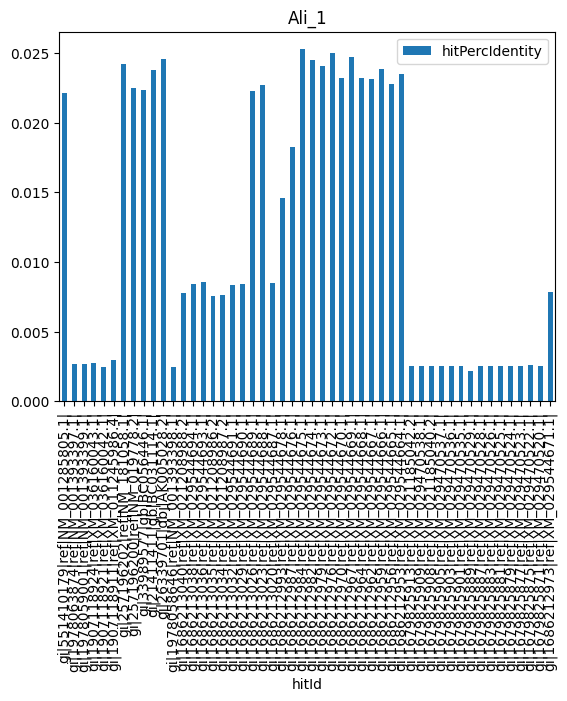

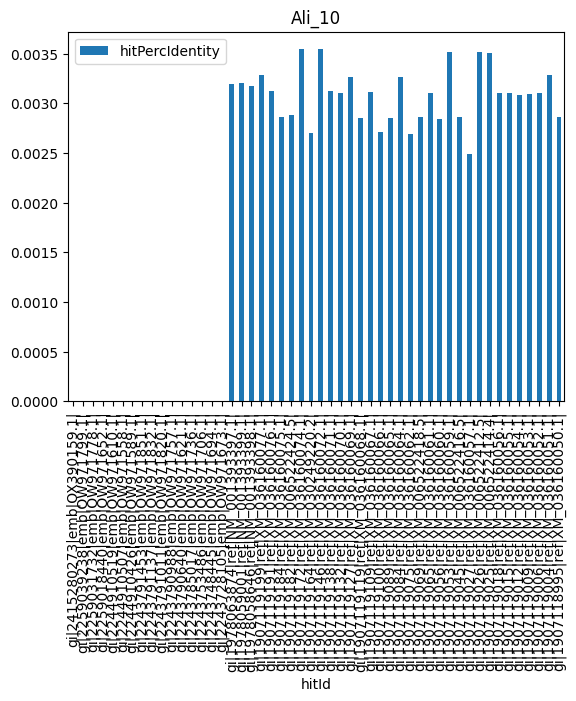

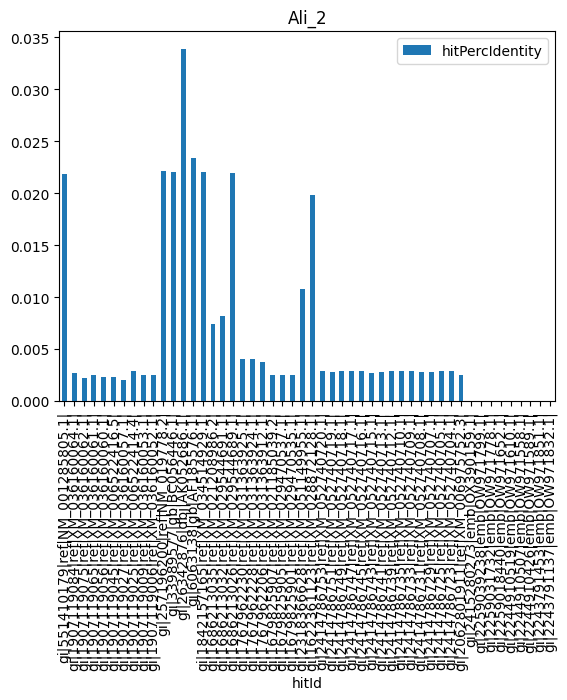

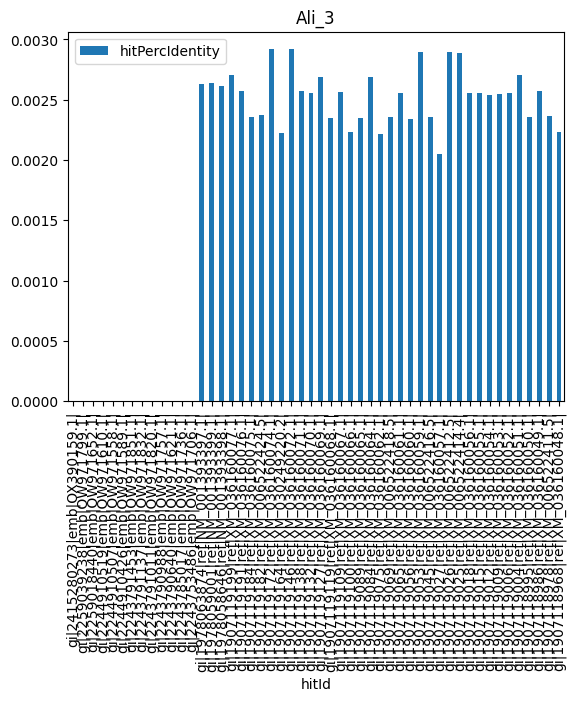

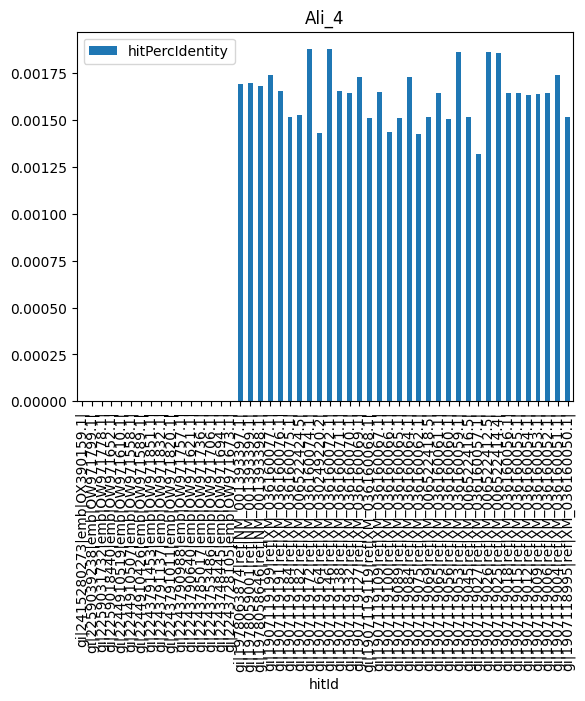

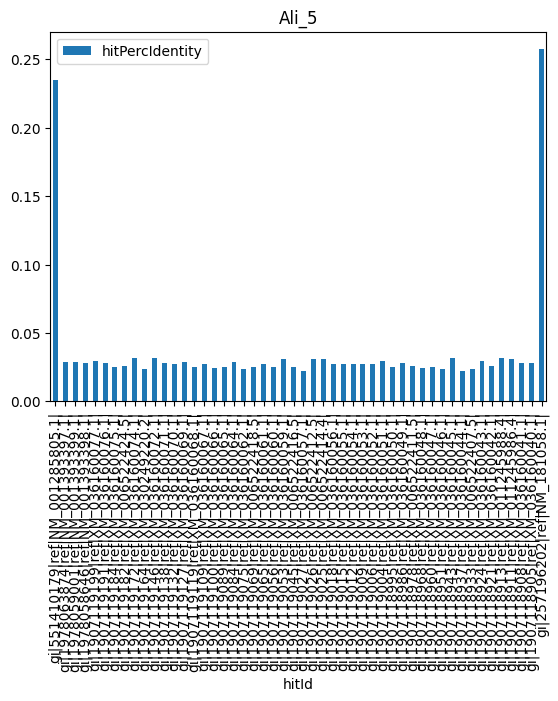

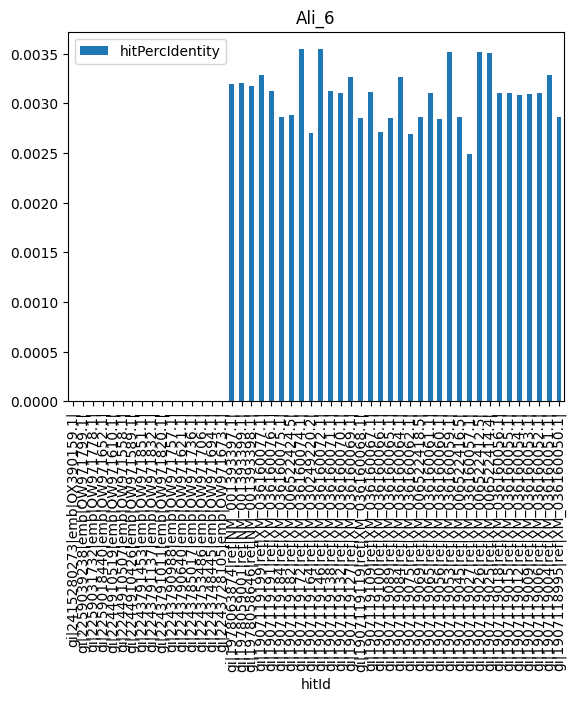

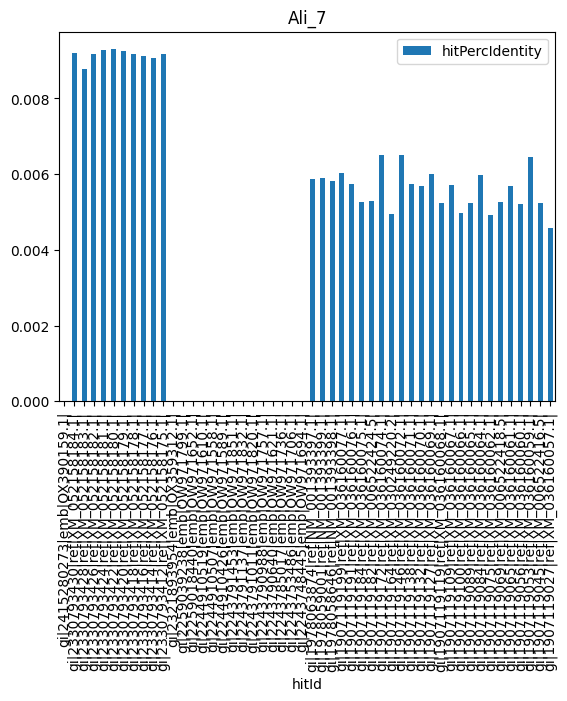

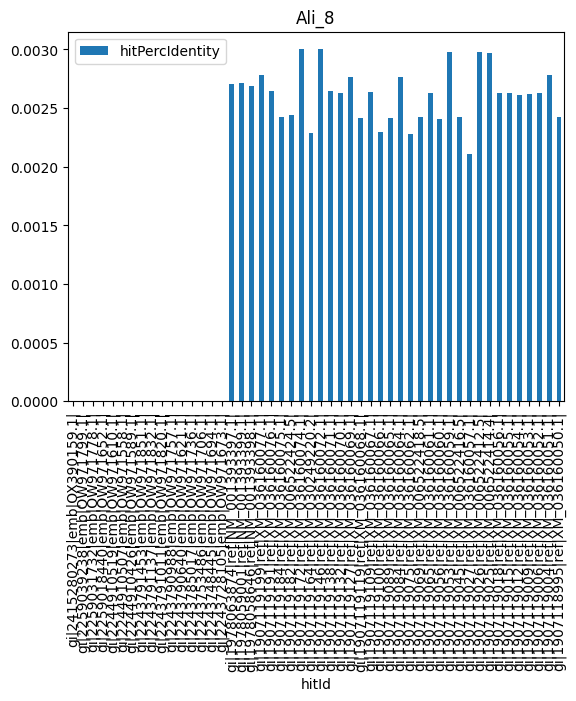

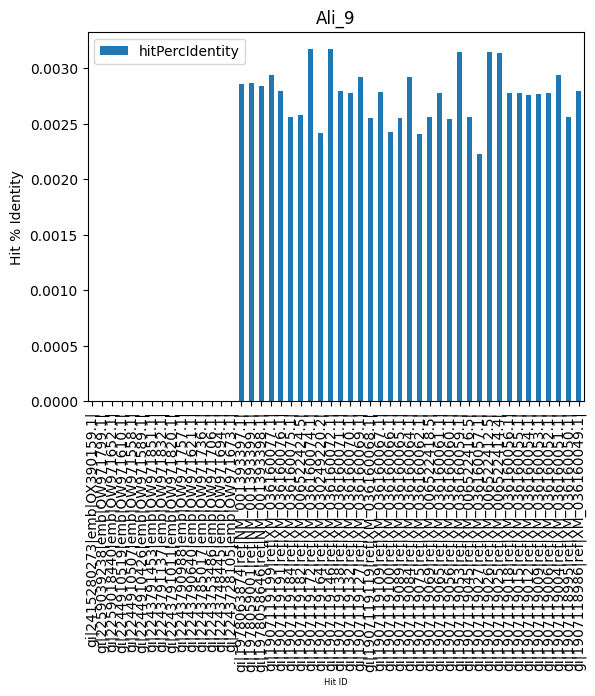

In [12]:
# Create a bar chart for each sequence using groupby
results.groupby('QuerySeqName').apply(lambda x: x.plot.bar(x='hitId', y='hitPercIdentity', title=x.name))
ax = plt.gca()
ax.set_xlabel('Hit ID', fontsize=6)
ax.set_ylabel('Hit % Identity', fontsize=10)
#ax.set_title(x.name, fontsize=12)
# Show the charts
plt.show()

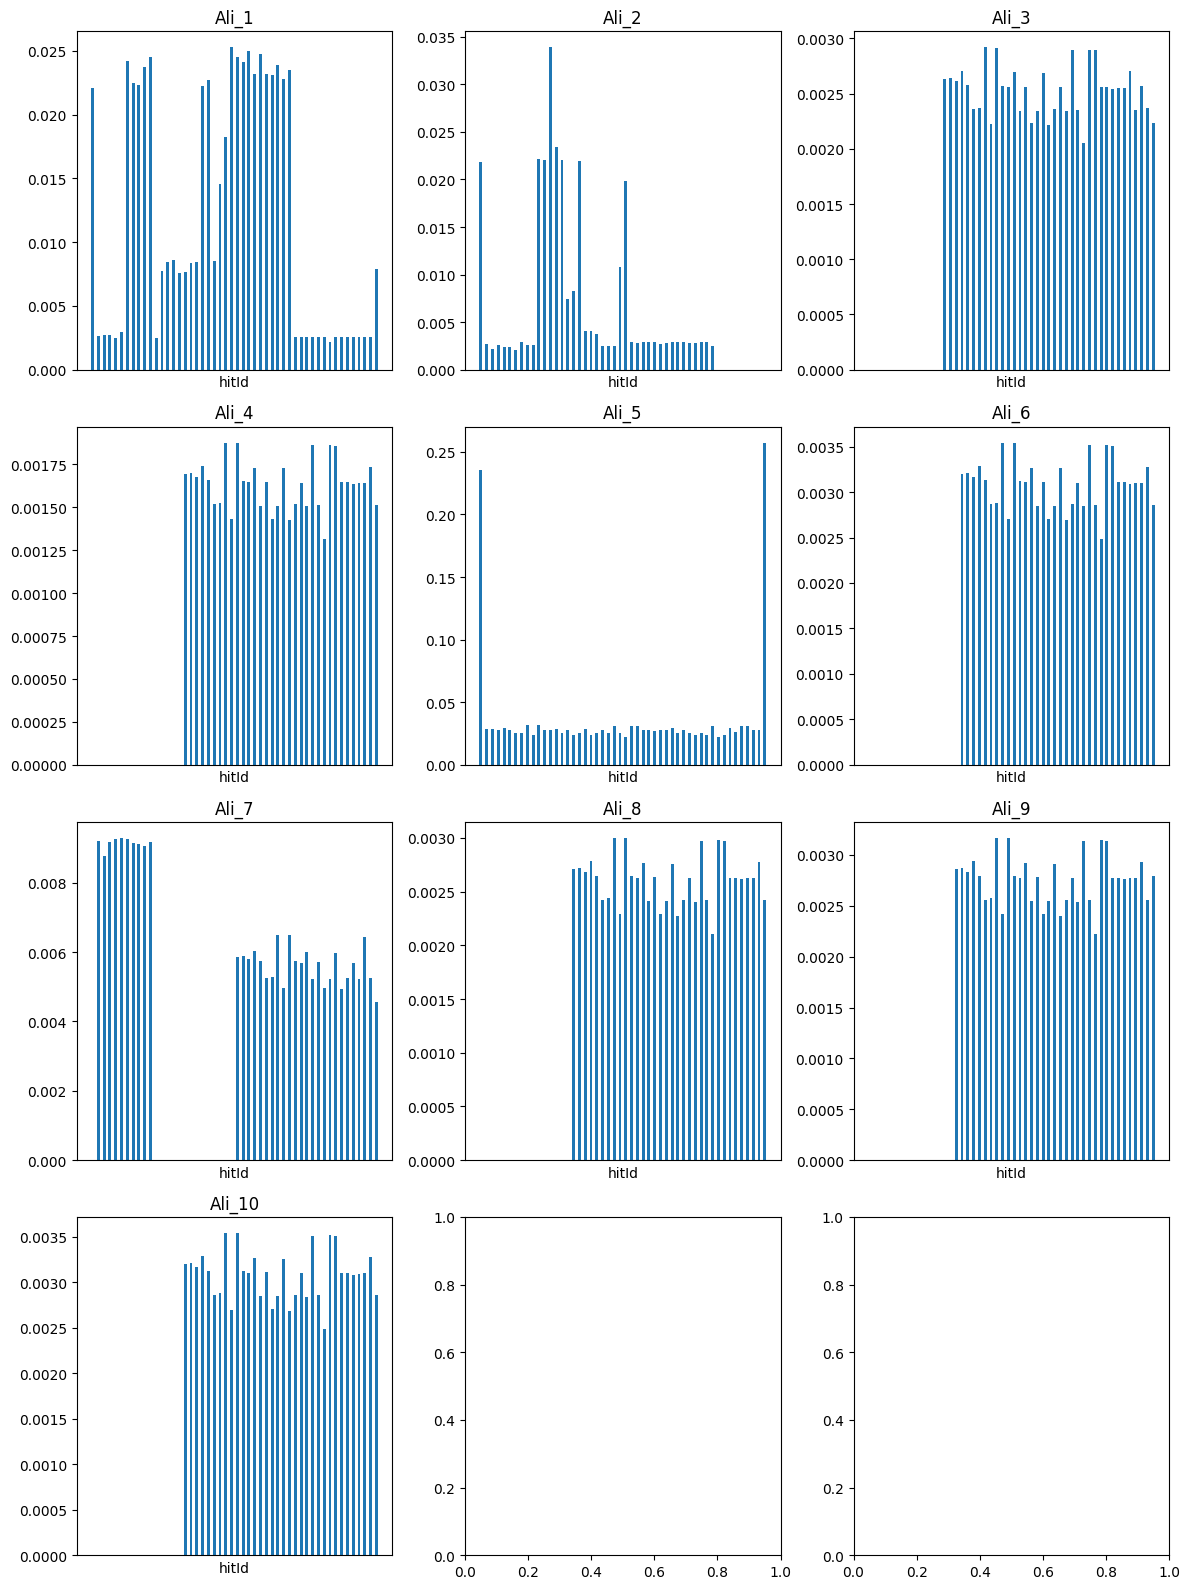

In [18]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns needed for the bar charts
nrows = 4
ncols = 3

# Create a figure with the specified number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))

# Loop through each unique query sequence name
for i, name in enumerate(results['QuerySeqName'].unique()):
    # Calculate the row and column index for this query sequence
    row_idx = i // ncols
    col_idx = i % ncols
    
    # Select data for this query sequence
    data = results.loc[results['QuerySeqName'] == name]
    
    # Add the bar chart for this query sequence to the corresponding subplot
    data.plot.bar(x='hitId', y='hitPercIdentity', title=name, ax=axes[row_idx, col_idx])
    
    # Hide the x-axis ticks and labels for all subplots
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_xticklabels([])
    
    # Remove the x-axis legend
    axes[row_idx, col_idx].legend().remove()
    
    # Adjust the layout of the subplot
    axes[row_idx, col_idx].autoscale(enable=True, axis='both', tight=True)
    axes[row_idx, col_idx].margins(0.05)
    
# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()
